# Clustering the Beaded Helix Transtion from R- to L-Helix

## Import Libraries and Define CV Subroutines

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
import MDAnalysis as md

In [2]:
def weighted_cross_validate_cluster_scan(traj_data, n_train_frames, cluster_array = np.arange(2,9,1).astype(int), n_partitions=10, n_attempts = 5, weighted_train_filename = "weighted_train.dat", weighted_predict_filename = "weighted_predict.dat"):
    # meta data from input array
    n_frames = traj_data.shape[0]
    # set parameters
    n_predict_frames = n_frames - n_train_frames
    print("Number of frames to train each model:", n_train_frames)
    print("Number of frames to predict each model:", n_predict_frames)
    sys.stdout.flush()
    # open data files
    weighted_train_log_lik = np.empty((cluster_array.size,n_partitions),dtype=np.float64)
    weighted_predict_log_lik = np.empty((cluster_array.size,n_partitions),dtype=np.float64)
    for partition in range(n_partitions):
        # shuffle trajectory data
        np.random.shuffle(traj_data)
        # create training and predict data
        train_data = traj_data[:n_train_frames]
        predict_data = traj_data[n_train_frames:]
        for cluster_index, cluster_size in enumerate(cluster_array):
            w_log_lik = []
            w_objs = []
            for attempt in range(n_attempts):
                wsgmm = gmm_shapes.ShapeGMM(cluster_size,kabsch_thresh=1e-1,init_cluster_method='random',init_iter=5, verbose=True)
                wsgmm.fit_weighted(train_data)
                w_log_lik.append(wsgmm.log_likelihood)
                w_objs.append(wsgmm)
            # determine maximum
            w_arg = np.argmax(w_log_lik)
            # save training log likes
            weighted_train_log_lik[cluster_index,partition] = w_log_lik[w_arg]
            # save prediction log likes
            weighted_predict_log_lik[cluster_index,partition] = w_objs[w_arg].predict_weighted(predict_data)[2]


    # write to data files
    weighted_train_file = open(weighted_train_filename,"w")
    weighted_predict_file = open(weighted_predict_filename,"w")
    # initialize counter
    count = 0
    for cluster_index, cluster_size in enumerate(cluster_array):
        weighted_train_file.write("%d" % (cluster_size))
        weighted_predict_file.write("%d" % (cluster_size))
        for partition in range(n_partitions):
            # write to training files
            weighted_train_file.write("%32.8f" % (weighted_train_log_lik[cluster_index,partition]))
            # write to predict files
            weighted_predict_file.write("%32.8f" % (weighted_predict_log_lik[cluster_index,partition]))
        # new line in files and flush buffer
        weighted_train_file.write("\n")
        weighted_train_file.flush()
        weighted_predict_file.write("\n")
        weighted_predict_file.flush()
        count += 1
    # close files
    weighted_train_file.close()
    weighted_predict_file.close()
    return weighted_train_log_lik, weighted_predict_log_lik

In [3]:
# reorder cluster numbers based on populations in descending order
def reorder_gmm_cluster_obj(sgmm_obj):
    # determine metadata based on clusters
    n_frames = sgmm_obj.n_frames
    cluster_ids, cluster_populations = np.unique(sgmm_obj.clusters,return_counts=True)
    n_clusters = cluster_ids.size
    print("Number of clusters:", n_clusters)
    print("Populations prior to reorder:", cluster_populations/n_frames)
    # determine sort key
    sort_key = np.argsort(cluster_populations)[::-1]
    sorted_cluster_ids = cluster_ids[sort_key]
    new_clusters = np.empty(n_frames,dtype=int)
    for frame in range(n_frames):
        new_clusters[frame] = np.argwhere(sorted_cluster_ids == sgmm_obj.clusters[frame])
    cluster_ids, cluster_populations = np.unique(new_clusters,return_counts=True)
    print("Populations after reorder:", cluster_populations/n_frames)
    # repopulate object
    sgmm_obj.precisions = sgmm_obj.precisions[sort_key]
    sgmm_obj.lpdets = sgmm_obj.lpdets[sort_key]
    sgmm_obj.centers = sgmm_obj.centers[sort_key]
    sgmm_obj.weights = sgmm_obj.weights[sort_key]
    sgmm_obj.ln_weights = sgmm_obj.ln_weights[sort_key]
    sgmm_obj.clusters = new_clusters

## Read trajectory

In [4]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
trajData = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    trajData[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation Cluster Scan (can take a while)

In [7]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)

In [ ]:
# run cluster CV scan
weighted_train_log_lik, weighted_predict_log_lik = weighted_cross_validate_cluster_scan(trajData,1000,cluster_array = cluster_array, n_partitions=10, weighted_train_filename="weighted_train_2_7.dat", weighted_predict_filename="weighted_predict_2_7.dat")

In [27]:
# load data from txt file if you don't want to run
weighted_train_log_lik = np.loadtxt("weighted_train_2_7.dat")[:,1:]
weighted_predict_log_lik = np.loadtxt("weighted_predict_2_7.dat")[:,1:]

## Make Log Likelihood vs number of Cluster Plots

In [28]:
# divide log likelihoods by number of frames in each
weighted_train_log_lik /= 1000.0
weighted_predict_log_lik /= 9001.0

In [29]:
cluster_array = np.arange(2,8,1).astype(int)

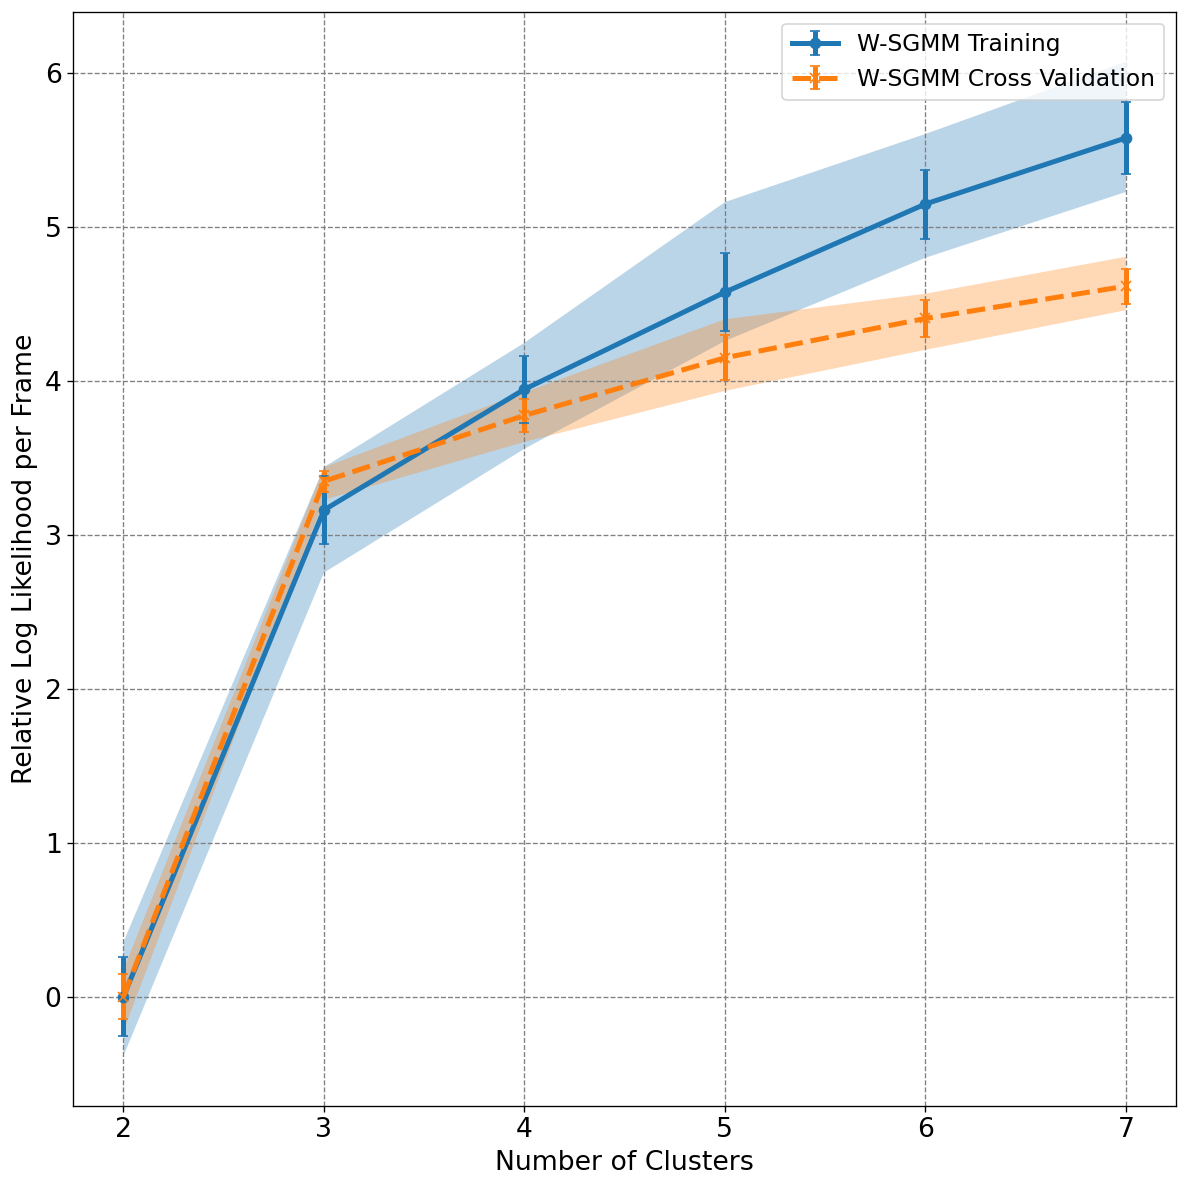

In [30]:
# create figure
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
# weighted SGMM
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
weighted_train_mean_min = np.amin(weighted_train_mean)
weighted_train_mean -= weighted_train_mean_min
weighted_train_log_lik -= weighted_train_mean_min
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
weighted_predict_mean_min = np.amin(weighted_predict_mean)
weighted_predict_mean -= weighted_predict_mean_min
weighted_predict_log_lik -= weighted_predict_mean_min
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Relative Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig("beaded_helix_log_likelihood_cv.png",dpi=300,transparent=True)

## Run WSGMM for nClusters=3

In [11]:
delta = 1
beaded_helix_3_clusters_wsgmm = gmm_shapes.ShapeGMM(3,verbose=True)
aligned_traj =  beaded_helix_3_clusters_wsgmm.fit_weighted(trajData[1::delta]) # start at 1

Weights from initial clusters in fit_weighted: [0.5181 0.087  0.3949]
0 [0.48029431 0.10562315 0.41408254] 401866.1347954833
1 [0.4715389  0.12551971 0.40294139] 423666.80724138307
2 [0.47192659 0.1306423  0.39743111] 433290.6955362656
3 [0.47045034 0.13458773 0.39496193] 434035.19624890946
4 [0.46956881 0.13651988 0.39391131] 434365.23765643267
5 [0.46898145 0.13760197 0.39341658] 434504.3064518818
6 [0.46861772 0.13822745 0.39315483] 434558.1328842576
7 [0.46841714 0.13858623 0.39299664] 434579.28781049006
8 [0.46832114 0.13878652 0.39289233] 434587.31761571043
9 [0.46827868 0.13890149 0.39281983] 434590.23513482575
10 [0.4682613  0.13897009 0.39276861] 434591.4211001013
11 [0.4682545  0.13901281 0.39273269] 434591.92149620136
12 [0.46825104 0.13904109 0.39270787] 434592.12157690007
13 [0.46825043 0.13905858 0.39269099] 434592.25651010213
14 [0.46825173 0.13906862 0.39267966] 434592.35382072354
15 [0.46825414 0.13907398 0.39267188] 434592.4282206508
16 [0.46825711 0.13907625 0.392666

In [19]:
# reorder object
reorder_gmm_cluster_obj(beaded_helix_3_clusters_wsgmm)

Number of clusters: 3
Populations prior to reorder: [0.465  0.1456 0.3894]
Populations after reorder: [0.465  0.3894 0.1456]


In [60]:
#predict if you didn't train on entire data set
entire_traj_clusters, entire_traj_traj, entire_traj_log_lik = beaded_helix_3_clusters_wsgmm.predict_weighted(trajData[1:])

## Make 2D FE Plot with clusterings

In [7]:
from shapeGMM._traj_tools import weight_kabsch_dist_align

In [20]:
mahaClusterCenters = np.empty((trajData[1::delta].shape[0],2),dtype=np.float32)
for frame in range(trajData[1::delta].shape[0]):
    mahaClusterCenters[frame,0] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame],beaded_helix_3_clusters_wsgmm.centers[0],beaded_helix_3_clusters_wsgmm.precisions[0]))
    mahaClusterCenters[frame,1] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame],beaded_helix_3_clusters_wsgmm.centers[1],beaded_helix_3_clusters_wsgmm.precisions[1]))

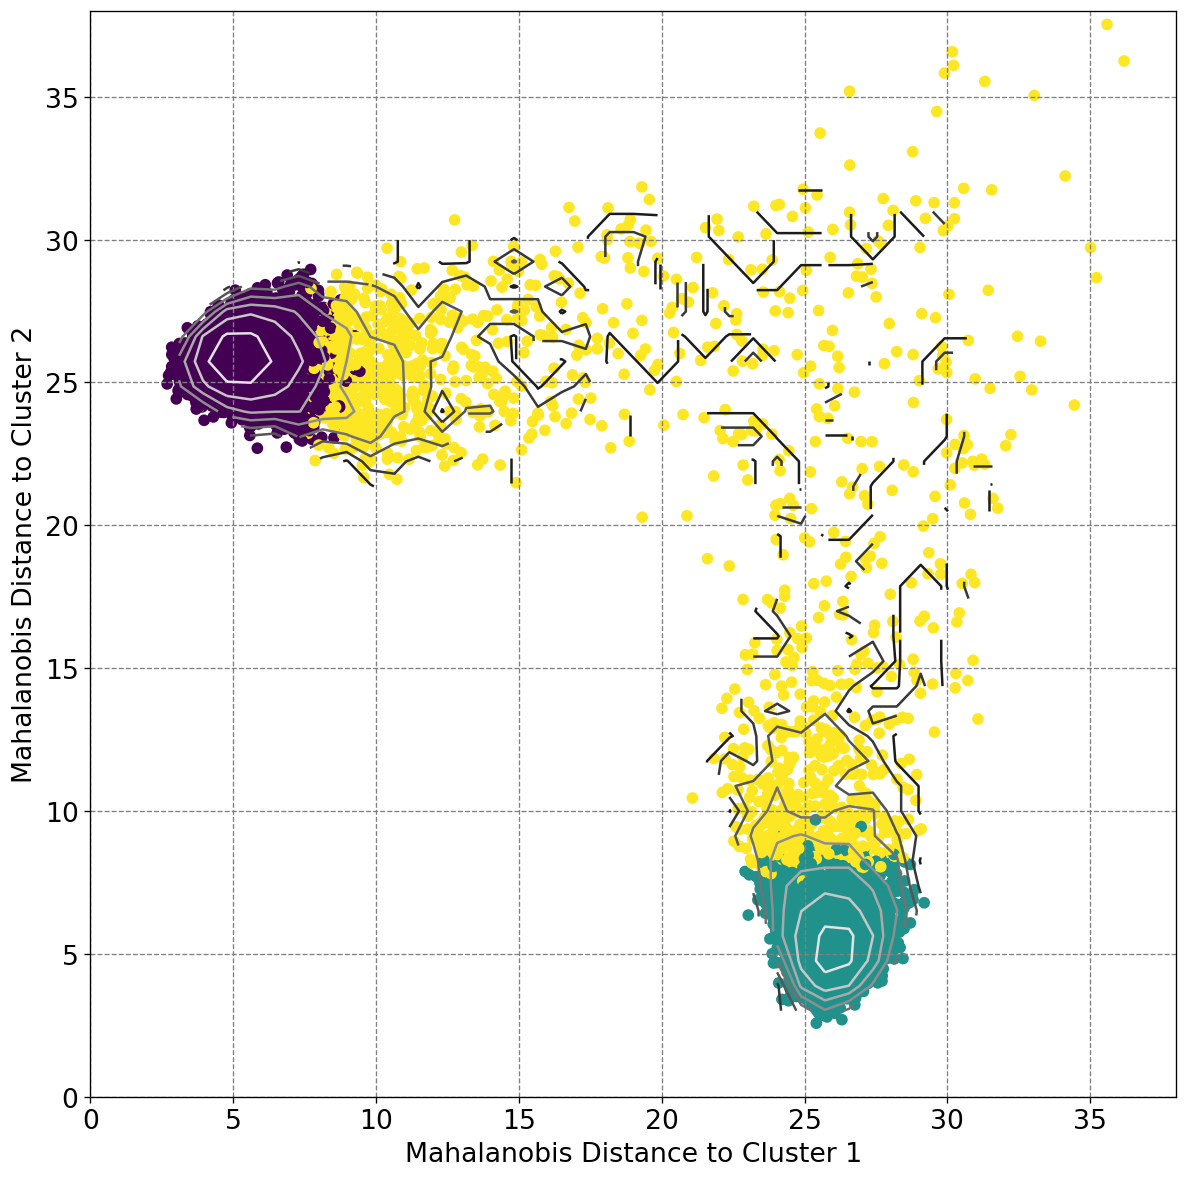

In [21]:
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
x = mahaClusterCenters[:,0]
y = mahaClusterCenters[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.ylabel("Mahalanobis Distance to Cluster 2",fontsize=16)
plt.xlabel("Mahalanobis Distance to Cluster 1",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.scatter(mahaClusterCenters[:,0],mahaClusterCenters[:,1],c=beaded_helix_3_clusters_wsgmm.clusters)#,alpha=0.2)
plt.tight_layout()
plt.xlim(0,38)
plt.ylim(0,38)
plt.axes().set_aspect('equal')
#plt.savefig("beaded_helix_2D_FE_w_clusters.eps",dpi=300)